In [1]:
# Import all the libraries needed
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import json
# Convert an address into latitude and longitude values
from geopy.geocoders import Nominatim
import requests
# Tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns

from sklearn.cluster import KMeans

import folium 

# Ignore the warnings
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# Open the json file 
with open('nyu_geojson.json') as json_data:
    newyork_data = json.load(json_data)

In [3]:
# Tranform JSON file into a pandas dataframe            
neighborhoods_data = newyork_data['features']

column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude']
neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [4]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [8]:
for i,c in enumerate(neighborhoods['Latitude']):
    print(c)
    break

40.89470517661


In [13]:
# Use geopy library to get the latitude and longitude values of New York City.
address = 'New York City, NY'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
# Create a map of New York with neighborhoods
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    # Add interactive labels
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    # This is a important method
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='Red',
        fill=True,
        fill_color='#cc8631',
        fill_opacity=0.5,
        parse_html=False).add_to(map_newyork) 

In [11]:
map_newyork

In [7]:
# Foursquare ID, Secret, API version, searching radius and searching limit
CLIENT_ID = 'PGRLJGYK2UMAAYQECG4OGDDLWJT22DMLE2SFQIPSY43SIJZ0' # your Foursquare ID
CLIENT_SECRET = 'RO4ZIO2WY2IVWVC0X1X5QYYTKPDGTVF1VWG2LDPPJGRU0XZM' # your Foursquare Secret
VERSION = '20180604'
radius = 500
LIMIT = 100

In [8]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [9]:
# Get all Venues of all neighborhoods
NY_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [10]:
print(NY_venues.shape)

(10288, 7)


In [11]:
NY_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,Shell,40.894187,-73.845862,Gas Station
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


In [12]:
print('There are {} uniques categories.'.format(len(NY_venues['Venue Category'].unique())))

There are 429 uniques categories.


In [13]:
# one hot encoding
NY_onehot = pd.get_dummies(NY_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
NY_onehot['Neighborhood'] = NY_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [NY_onehot.columns[-1]] + list(NY_onehot.columns[:-1])
NY_onehot = NY_onehot[fixed_columns]
NY_grouped = NY_onehot.groupby('Neighborhood').mean().reset_index()

In [14]:
NY_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Cafeteria,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Hunan Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Ne

In [15]:
NY_grouped.shape

(300, 429)

In [16]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10
indicators = ['st', 'nd', 'rd']
columns = ['Neighborhood']

for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = NY_grouped['Neighborhood']

for ind in np.arange(NY_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(NY_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,Deli / Bodega,Chinese Restaurant,Pizza Place,Supermarket,Intersection,Grocery Store,Bakery,Electronics Store,Martial Arts Dojo,Gas Station
1,Annadale,Liquor Store,American Restaurant,Train Station,Diner,Restaurant,Pizza Place,Sports Bar,Food,Flower Shop,Farmers Market
2,Arden Heights,Pizza Place,Pharmacy,Coffee Shop,Home Service,Women's Store,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor
3,Arlington,Bus Stop,American Restaurant,Coffee Shop,Boat or Ferry,Pizza Place,Women's Store,Filipino Restaurant,Event Space,Exhibit,Eye Doctor
4,Arrochar,Deli / Bodega,Italian Restaurant,Pizza Place,Bus Stop,Food Truck,Hotel,Sandwich Place,Athletics & Sports,Supermarket,Bagel Shop


In [17]:
neighborhoods_venues_sorted.shape

(300, 11)

In [18]:
from scipy.spatial.distance import cdist, pdist


def elbow(data,K):
#data is your input as numpy form
#K is a list of number of clusters you would like to show.
    # Run the KMeans model and save all the results for each number of clusters
    KM = [KMeans(n_clusters=k).fit(data) for k in K]
    
    # Save the centroids for each model with a increasing k
    centroids = [k.cluster_centers_ for k in KM]

    # For each k, get the distance between the data with each center. 
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
    
    # But we only need the distance to the nearest centroid since we only calculate dist(x,ci) for its own cluster.
    globals()['dist'] = [np.min(D,axis=1) for D in D_k]
    
    # Calculate the Average SSE.
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    
    
    # elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    plt.show()
    
    
    # Total with-in sum of square plot. Another way to show the result.
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss-wcss
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained')
    plt.title('Elbow for KMeans clustering')
    plt.show()

In [19]:
Train_X = NY_grouped.drop('Neighborhood', 1)

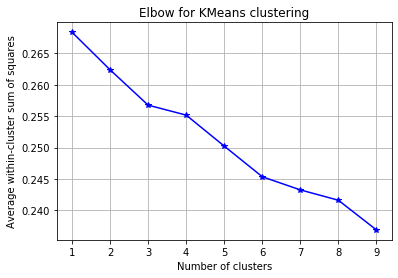

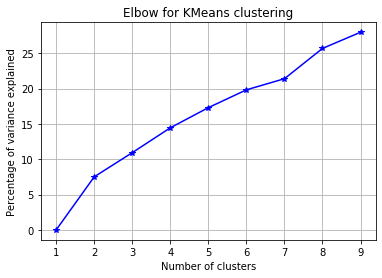

In [21]:
from matplotlib.pylab import plt
elbow(Train_X, range(1,10))

In [22]:
kclusters = 20
kmeans = KMeans(n_clusters=kclusters, random_state=2498).fit(Train_X) 
Labels = np.append(kmeans.labels_, [0,0,0,0,0,0], axis=0)

In [23]:
from collections import Counter
l = Counter(Labels)
l

Counter({4: 20,
         16: 44,
         14: 10,
         17: 64,
         9: 87,
         19: 1,
         3: 30,
         2: 17,
         12: 1,
         1: 2,
         6: 14,
         10: 1,
         5: 1,
         8: 1,
         11: 1,
         13: 1,
         15: 1,
         0: 8,
         18: 1,
         7: 1})

# Use NY_grouped might be a bad idea because of too many features.
# Should One-Hot coding the sorted set 
# Or just use a different algorithm

In [24]:
neighborhoods['Cluster'] = Labels
NY_merged = neighborhoods
NY_merged = NY_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

In [25]:
NY_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bronx,Wakefield,40.894705,-73.847201,4,Donut Shop,Pharmacy,Ice Cream Shop,Caribbean Restaurant,Dessert Shop,Gas Station,Sandwich Place,Laundromat,Women's Store,Event Space
1,Bronx,Co-op City,40.874294,-73.829939,16,Bus Station,Baseball Field,Bar,Discount Store,Fast Food Restaurant,Pharmacy,Park,Pizza Place,Restaurant,Grocery Store
2,Bronx,Eastchester,40.887556,-73.827806,16,Bus Station,Caribbean Restaurant,Deli / Bodega,Metro Station,Diner,Platform,Seafood Restaurant,Bakery,Fast Food Restaurant,Donut Shop
3,Bronx,Fieldston,40.895437,-73.905643,14,River,Bus Station,Plaza,Women's Store,Filipino Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory
4,Bronx,Riverdale,40.890834,-73.912585,16,Bus Station,Park,Bank,Plaza,Gym,Baseball Field,Home Service,Food Truck,Dim Sum Restaurant,Diner


In [26]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
#here!!
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]



# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(NY_merged['Latitude'], NY_merged['Longitude'], NY_merged['Neighborhood'], NY_merged['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color = rainbow[cluster-2],
        fill_color = rainbow[cluster-2],
        fill=True,
        
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [ ]:
df1 = NY_merged.loc[NY_merged['Cluster'] == 0, NY_merged.columns[[1] + list(range(5, NY_merged.shape[1]))]]
df1

In [ ]:
df2 = NY_merged.loc[NY_merged['Cluster'] == 1, NY_merged.columns[[1] + list(range(5, NY_merged.shape[1]))]]
df2

In [ ]:
df3 = NY_merged.loc[NY_merged['Cluster'] == 3, NY_merged.columns[[1] + list(range(5, NY_merged.shape[1]))]]
df3

In [ ]:
df4 = NY_merged.loc[NY_merged['Cluster'] == 4, NY_merged.columns[[1] + list(range(5, NY_merged.shape[1]))]]
df4

In [ ]:
df5 = NY_merged.loc[NY_merged['Cluster'] == 7, NY_merged.columns[[1] + list(range(5, NY_merged.shape[1]))]]
df5